<a href="https://colab.research.google.com/github/AJAkil/All-things-AI/blob/master/Practice_Metric_Learning_DeepCourse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -rf *.tgz*
!wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
!tar zxf lfw-deepfunneled.tgz

--2023-01-09 08:32:12--  http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108761145 (104M) [application/x-gzip]
Saving to: ‘lfw-deepfunneled.tgz’

lfw-deepfunneled.tg 100%[===================>] 103.72M   101MB/s    in 1.0s    

2023-01-09 08:32:13 (101 MB/s) - ‘lfw-deepfunneled.tgz’ saved [108761145/108761145]



In [15]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.8/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['copy', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [34]:
import glob
import os
import collections
import random
import copy

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
os.listdir("lfw-deepfunneled")[:10], os.listdir("lfw-deepfunneled")[-10:]

(['Pervez_Musharraf',
  'Roger_Winter',
  'Kelly_Osbourne',
  'Yuvraj_Singh',
  'Sarah_Weddington',
  'Van_Hilley',
  'Brian_Cook',
  'Nadia_Forte',
  'Brian_Clemens',
  'Bernadette_Peters'],
 ['Ulrich_Kueperkoch',
  'Scott_Rudin',
  'Guillermo_Ortiz',
  'Eric_Hinske',
  'Oracene_Williams',
  'Don_Meredith',
  'Dwain_Kyles',
  'Diego_Colorado',
  'Freddy_Garcia',
  'Bob_Holden'])

In [ ]:
names = sorted(os.listdir('lfw-deepfunneled'))
name_to_classid = {data: index for index, data in enumerate(names)}
classid_to_name = {data: index for index, data in name_to_classid.items()}

# creating class ID to path dictionary
def build_data_set(names_list, start_index, end_index):
  classid_to_paths = collections.defaultdict(list)
  counter = 0
  for name in names[start_index:end_index]:
    class_id = name_to_classid[name]
    for image_name in os.listdir(f"lfw-deepfunneled/{name}"):
      classid_to_paths[class_id].append(f"lfw-deepfunneled/{name}/{image_name}")
      counter += 1
  
  print(f"Number of person: {len(classid_to_paths)}")
  print(f"Number of images: {counter}")

  return classid_to_paths

In [28]:
print('Build Train Set...')
train_set = build_data_set(names, 0, 500)
print('Build Validation Set...')
val_set = build_data_set(names, 500, 1000)

Build Train Set...
Number of person: 500
Number of images: 1155
Build Validation Set...
Number of person: 500
Number of images: 945


Train Set: {Id: [image path 1, image path 2], .... }

Analyzing the distribution of celebrity images by frequency plots

Text(0.5, 0, 'Nb images / person')

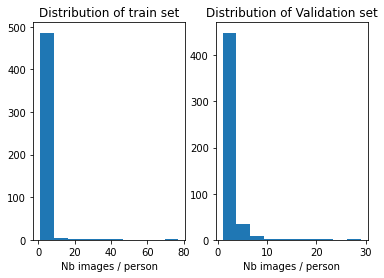

In [29]:
plt.subplot(1,2,1)
train_occurence = {classid_to_name[class_id]: len(paths) for class_id, paths in train_set.items()}
plt.hist(train_occurence.values())
plt.title("Distribution of train set")
plt.xlabel("Nb images / person")


plt.subplot(1,2,2)
test_occurence = {classid_to_name[class_id]: len(paths) for class_id, paths in test_set.items()}
plt.hist(test_occurence.values())
plt.title("Distribution of Validation set")
plt.xlabel("Nb images / person")

In [30]:
for name, nb in sorted(train_occurence.items(), key=lambda x: x[1], reverse=True)[:20]:
  print(f"{name}: {nb} images")

Ariel_Sharon: 77 images
Arnold_Schwarzenegger: 42 images
Alejandro_Toledo: 39 images
Andre_Agassi: 36 images
Alvaro_Uribe: 35 images
Atal_Bihari_Vajpayee: 24 images
Amelie_Mauresmo: 21 images
Angelina_Jolie: 20 images
Abdullah_Gul: 19 images
Andy_Roddick: 15 images
Ari_Fleischer: 13 images
Adrien_Brody: 12 images
Anna_Kournikova: 12 images
Ann_Veneman: 11 images
Al_Gore: 8 images
Ali_Naimi: 8 images
Ana_Palacio: 8 images
Antonio_Palocci: 8 images
Al_Sharpton: 7 images
Amelia_Vega: 7 images


## Building Positive and negative pairs of images

In [31]:
def build_pairs(classid_to_paths, pair_per_class=50):
  """
  we are creating equal number of positive and negative pairs to
  make it more balanced
  """
  pairs = [] # a list of tuple - (img_path1, img_path2, 1) (pos pair), (img_path1, img_path2, 0) (neg pair)
  classes = set(classid_to_paths.keys())

  for class_id in classid_to_paths:
    num_img_class = len(classid_to_paths[class_id])

    if num_img_class == 1:
      continue
    
    for _ in range(min(num_img_class, pair_per_class)):
      
      # positive pair
      pairs.append((
          random.choice(classid_to_paths[class_id]),
          random.choice(classid_to_paths[class_id]),
          1.0
      ))

      # creating a negative class id
      neg_classes = classes - {class_id}
      neg_class_id = random.choice(list(neg_classes))

      # negative pair
      pairs.append((
          random.choice(classid_to_paths[class_id]),
          random.choice(classid_to_paths[neg_class_id]),
          0.0
      ))
  return pairs

In [53]:
class SiameseDataset(torch.utils.data.Dataset):
  def __init__(self, classid_to_paths, transform, pair_per_class=20):
    self.transform = transform
    self.pairs = build_pairs(classid_to_paths, pair_per_class=pair_per_class)
  
  def __len__(self):
    return len(self.pairs)

  def __getitem__(self, index):
    img_1, img_2, y = self.pairs[index]

    left_img  = Image.open(img_1).convert('RGB')
    right_img = Image.open(img_2).convert('RGB')

    left_img  = self.transform(left_img)
    right_img = self.transform(right_img)

    return left_img, right_img, y 

## Building Data Augmentations and Data loaders

In [54]:
train_transform = transforms.Compose([
    transforms.Resize((100,100)),
    transforms.CenterCrop((80,80)),
    transforms.ColorJitter(brightness=0.2),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((100,100)),
    transforms.CenterCrop((80,80)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

train_dataset = SiameseDataset(train_set, train_transform, pair_per_class=50)
val_dataset = SiameseDataset(val_set, train_transform, pair_per_class=50)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(val_dataset, batch_size=32)

len(train_loader)

49

In [55]:
x1, x2, y = next(iter(train_loader))

x1.shape, x2.shape, y

(torch.Size([32, 3, 80, 80]),
 torch.Size([32, 3, 80, 80]),
 tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0.,
         1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0.],
        dtype=torch.float64))

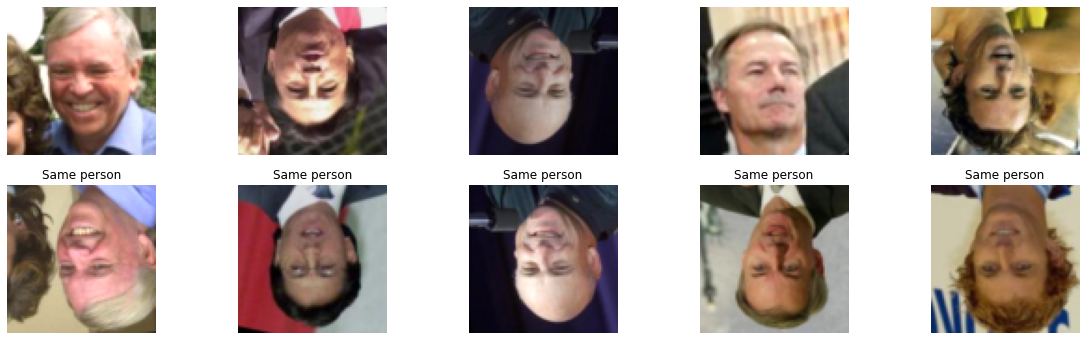

In [57]:
plt.figure(figsize=(20, 6))

for i in range(5):
  ax = plt.subplot(2, 5, i + 1)
  ax.axis('off')
  img = (x1[i].permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
  plt.imshow(img)

for i in range(5):
  ax = plt.subplot(2, 5, i + 1 + 5)
  ax.axis('off')
  img = (x2[i].permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
  plt.imshow(img)
  plt.title("Same person" if y[i] == 1.0 else "Different person")